# fu 验证calipso过境图

# Evaluate Models by Cases

In [1]:
# 导入必要的模块
import pandas as pd
import numpy as np
import xarray as xr
import datetime
from datetime import timedelta
# from sklearn.model_selection import train_test_split
# from sklearn import preprocessing
# from sklearn.metrics import confusion_matrix  # 导入计算混淆矩阵的包pp
# from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # 导入包
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import sys
import pyhdf.SD        # must prefix names with "pyhdf.SD."
from pyhdf import SD   # must prefix names with "SD."
from pyhdf.SD import * # names need no prefix

In [2]:
sys.path
sys.path.append('/home/fuhy/data/SWC/code/preprocessing/readmatch')
import readX # type: ignore
# import importlib
# importlib.reload(readX.readERA)
from imp import reload
# reload(readX.readH8)
from readX.readH8 import readH8data # type: ignore
from readX.readERA import readERAsl, readERApl # type: ignore
from readX.readMOD import readMOD11 # type: ignore

/tmp/ipykernel_50211/3822622085.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# import importlib
# importlib.reload(readX.readERA)
# from readX.readH8 import readH8data # type: ignore
# from readX.readERA import readERAsl, readERApl # type: ignore
# from readX.readMOD import readMOD11 # type: ignore

## 个例
读成矩阵

In [3]:
#%% 选取一个H8Timelist
pathTimelist = '/home/public/data/H8/L1/201612/01/NC_H08_20161201_0000_R21_FLDK.06001_06001.nc'
H8Timelist = xr.open_dataset(pathTimelist)['Hour']
H8Timelist


<xarray.DataArray 'Hour' (latitude: 6001, longitude: 6001)>
[36012001 values with dtype=timedelta64[ns]]
Coordinates:
  * latitude   (latitude) float32 60.0 59.98 59.96 59.94 ... -59.96 -59.98 -60.0
  * longitude  (longitude) float32 80.0 80.02 80.04 80.06 ... 200.0 200.0 200.0
Attributes:
    long_name:  observation hours (UT)
    valid_min:  -32767
    valid_max:  32767

In [4]:
#%% 输入路径数据
path_CALIPSO1 = '/home/public/data/CALIPSO/APro/2016/2020294060916_53390/' # '/home/public/data/CALIPSO/APro/2016/2020294055515_53389/'
path_CALIPSO2 = '/home/public/data/CALIPSO/APro/2017/002/' # '/home/public/data/CALIPSO/APro/2016/2020294060916_53390/'
name_CALIPSO  = 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T08-34-23ZD_Subset.hdf'

In [5]:
import os
CALnames=[filename for filename in
    os.listdir(path_CALIPSO1)
    # if filename.endswith('.hdf')]
    if filename.startswith('CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30')]

In [7]:
CALnames

['CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T00-20-02ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T01-58-53ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T03-37-48ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T05-16-38ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T06-55-33ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T08-34-23ZD_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T11-05-39ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T12-44-29ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T14-23-24ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T16-02-14ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T17-41-10ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T19-20-00ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T20-58-55ZN_Subset.hdf',
 'CAL_LID_L2_05kmAPro-Standard-V4-20.2016-07-30T23-24-20ZD_Subse

In [6]:
CALIPSO = SD(path_CALIPSO1+name_CALIPSO) # type: ignore
# %%
df = pd.DataFrame()
df['dt']  = CALIPSO.select('Profile_UTC_Time')[:,1]
df['lat'] = CALIPSO.select('Latitude')[:,1]
df['lon'] = CALIPSO.select('Longitude')[:,1]

### Read Himawari-8

In [8]:
#%%
# Himawari-8
from warnings import simplefilter
simplefilter(action="ignore",category=FutureWarning)   # 不显示future warining
from imp import reload
reload(readX.readH8)
path_H8     = '/home/public/data/H8/L1/'
H8bands = ['latitude','longitude','tbb_07', 'SAZ','name_H8']
df_H8 = readH8data(df['dt'], df['lat'], df['lon'], H8bands, path_H8, H8Timelist)

H8 matching for 20160730.3593678264:  11%|█         | 67/625 [00:57<00:37, 14.97it/s] 

### Read ERA-5

In [23]:
# Single levels

# 2016 path
# pathnameERA1 = '/home/public/data/ERA5/reanalysis-era5-single-levels/2016_surface_pressure.nc'
# pathnameERA2 = '/home/public/data/ERA5/reanalysis-era5-single-levels/2016_tcwv_skt.nc'
# varnames1 = ['sp']
# varnames2 = ['skt', 'tcwv']
# df_ERAsl1 = readERAsl(df['lat'], df['lon'], df['dt'], varnames1, pathnameERA1)
# df_ERAsl2 = readERAsl(df['lat'], df['lon'], df['dt'], varnames2, pathnameERA2)
# df_ERAsl = pd.concat([df_ERAsl1, df_ERAsl2], axis=1)

# 2017 path
pathnameERA = '/home/public/data/ERA5/reanalysis-era5-single-levels/2017_tcwv_skt_sp_fa.nc'
varnames = ['sp', 'skt', 'tcwv']
df_ERAsl = readERAsl(df['lat'], df['lon'], df['dt'], varnames, pathnameERA)

In [24]:
# Pressure levels

# dict根据匹配目标ERA数据及命名规则需更新
dictERA = {
    'o3': 'ozone_mass_mixing_ratio_',
    'q': 'specific_humidity_',
    't': 'temperature_',
    }
plevels = [200, 500, 850, 1000]
pathERApl = '/home/public/data/ERA5/reanalysis-era5-pressure-levels/'

df_ERApl_o3 = readERApl(df['lat'], df['lon'], df['dt'], 'o3', plevels, pathERApl, dictERA)
df_ERApl_q = readERApl(df['lat'], df['lon'], df['dt'], 'q', plevels, pathERApl, dictERA)
df_ERApl_t = readERApl(df['lat'], df['lon'], df['dt'], 't', plevels, pathERApl, dictERA)

df_ERApl = pd.concat([df_ERApl_o3, df_ERApl_q, df_ERApl_t], axis=1)

### Read MOD11 surface emissivities

In [25]:
pathMOD = '/home/fuhy/data/SWC/data/MOD11_origin_itp/'
df_MOD11 = readMOD11(df['lat'], df['lon'], df['dt'], pathMOD)

In [26]:
df = pd.concat([df, df_H8, df_ERAsl, df_ERApl, df_MOD11], axis=1)

## Load models
### XGBoost

In [76]:
import xgboost as xgb
# 读取模型
model = xgb.XGBClassifier()
model.load_model("/home/fuhy/data/SWC/model/xgbSWCall.json")

In [28]:
#%% Load scaler 载入已有标准化模型

istbb07 = False
if istbb07:
    scalerpath = "/home/fuhy/data/SWC/model/scaler_SWC1.sav"
else:
    scalerpath = "/home/fuhy/data/SWC/model/scaler_SWC0.sav"

scaler = load(scalerpath)

### Preprocessing and initialization

In [84]:
# pressure levels
varnames = ['o3', 'q', 't']
pressure_level = ['200','500','850','1000']
xnames = []
for varname in varnames:
    varnames1 = [varname + '_' + s for s in pressure_level]
    xnames = np.append(xnames, varnames1)
xnames

array(['o3_200', 'o3_500', 'o3_850', 'o3_1000', 'q_200', 'q_500', 'q_850',
       'q_1000', 't_200', 't_500', 't_850', 't_1000'], dtype='<U32')

In [29]:
df_X_case = df

# pressure levels
varnames = ['o3', 'q', 't']
pressure_level = ['200','500','850','1000']
xnames = []
for varname in varnames:
    varnames1 = [varname + '_' + s for s in pressure_level]
    xnames = np.append(xnames, varnames1)

# single levels
if istbb07:

    varnames = [
        'sp', 'skt', 'tcwv',
        'tbb_07', 'tbb_08', 'tbb_09', 'tbb_10', 'tbb_11', 'tbb_12', 'tbb_13', 'tbb_14',
        'tbb_15', 'tbb_16', 'SOZ', 'SAZ', 'DAA',
        'MOD11_Emis_20', 'MOD11_Emis_22', 'MOD11_Emis_23', 'MOD11_Emis_29',
        'MOD11_Emis_31', 'MOD11_Emis_32']

else:

    varnames = ['sp', 'skt', 'tcwv',
        # 受太阳光影响
        # 'albedo_01', 'albedo_02', 'albedo_03', 'albedo_04', 'albedo_05', 'albedo_06',
        # 'tbb_07', 
        # 'DAA', 'SOZ', 
        'tbb_08', 'tbb_09', 'tbb_10', 'tbb_11', 'tbb_12', 'tbb_13', 'tbb_14',
        'tbb_15', 'tbb_16', 'SAZ', 
        'MOD11_Emis_20', 'MOD11_Emis_22', 'MOD11_Emis_23', 'MOD11_Emis_29',
        'MOD11_Emis_31', 'MOD11_Emis_32']
    
xnames = np.append(xnames, varnames)
df_X_select = df_X_case[xnames]

In [77]:
# Model prediction

# Data initialization, standarization
X_case_scaled = scaler.transform(df_X_select)
# Prediction
preds_case = model.predict(X_case_scaled)

# 画图

### CALIPSO Cloud Phase

In [31]:
from re import sub


def altiProfile(data_ft1):
    """
    getProfile 制作完整profile
    % Get profiles with right altitude of CALIPSO L2 APro v4
    % 8.3km以下, 分辨率为30m, 以上为60m(180m)
    % below 8.3 km, the first dimension contains the descriptive flags of ...
    % the higher of the two full resolution (30 m) bins that comprise the single...
    % 60 m bin reported in the Profile Products. Meanwhile, below 8.3
    """
    data_ft = np.c_[data_ft1[:,:,0],data_ft1[:,:,1]]
    data_ft_origin = np.zeros((np.size(data_ft,0),544))
    data_ft_origin[:,0:254] = data_ft[:,0:254]          # Above 8.3km
    data_ft_origin[:,254:543:2] = data_ft[:,254:399]    # Below 8.3km, higher
    data_ft_origin[:,255:544:2] = data_ft[:,653:798]    # Below 8.3km, lower
    return data_ft_origin

## 生成Temperature廓线
def altiTProfile(data_T):
    # getProfile 制作完整profile
    # 与AVD廓线数据匹配
    data_T_origin = np.zeros((np.size(data_T,0),544))
    data_T_origin[:,0:254] = data_T[:,0:254]          # Above 8.3km
    data_T_origin[:,254:544:2] = data_T[:,254:399]    # higher, below 8.3km
    data_T_origin[:,255:545:2] = data_T[:,254:399]    # lower, below 8.3km
    return data_T_origin

In [32]:
### 计算CALIPSO的垂直高度
alt1 = np.arange(30.1-0.18, 20.2+1e-10, -0.18)
alt2 = np.arange(20.2, 8.2+1e-10, -0.06)
alt3 = np.arange(8.2, -0.5, -0.03)
assert (alt1.shape[0]==54) and (alt2.shape[0]==200) and (alt3.shape[0]==290)
alt = np.hstack([alt1,alt2,alt3])

In [33]:
lats, lons   = CALIPSO.select('Latitude')[:,1], CALIPSO.select('Longitude')[:,1]
masks_origin = CALIPSO.select('Atmospheric_Volume_Description')[:]
TPro     = CALIPSO.select('Temperature')[:]
masks = altiProfile(masks_origin).astype(np.int64)
TPro = altiTProfile(TPro)
### 利用特征分类信息得到云检测、云相态以及云型
cmask = masks & 7
score = (masks>>3) & 3 #classification confidence score: 0,1,2,3
cdec = (cmask==2) & (score>=2) #cloud detection
cphase = (masks>>5) & 3 #cloud phase
ctype = (masks>>9) & 7  #cloud type

In [34]:
# cmask, Bits 1-3 (CALIPSO L2 APro v4): 
#                     0 = invalid (bad or missing data)
#                     1 = “clear air”
#                     2 = cloud
#                     3 = tropospheric aerosol
#                     4 = stratospheric aerosol
#                     5 = surface
#                     6 = subsurface
#                     7 = no signal (totally attenuated)


In [35]:
# class water phase into WWC and SWC
'''
    cphase(original):
        0 = unknown / not determined
        1 = ice
        2 = water
        3 = oriented ice crystals


    cphase(output):
        0 = CS and N/A
            surface/subsurface
            "clear air" / tropospheric aerosol / stratospheric aerosol
            no signal (totally attenuated)
        1 = WWC
        2 = SWC
        3 = IC
        4 = UC
'''
# 各类型索引
# 确定晴空等N/A位置，与相态无关统一归结为N/A
idx_NA  = (cmask==0) | (cmask==1) | (cmask==3) | (cmask==4) | (cmask==5) | (cmask==6) | (cmask==7)
idx_WWC = (cmask==2) & (cphase==2) & (TPro>0)           # SWC
idx_SWC = (cmask==2) & (cphase==2) & (TPro<0)           # SWC
idx_ice = (cmask==2) & ((cphase==1) | (cphase==3))      # IC
idx_unknown = (cphase==0) & (cmask==2)                  # UC

cphase[idx_NA]  = 0
cphase[idx_WWC] = 1
cphase[idx_SWC] = 2                     # SWC = 2, so, WWC = 1
cphase[idx_ice] = 3
cphase[idx_unknown] = 4
np.unique(cphase)


array([0, 1, 2, 3, 4])

## CALIPSO匹配results

In [4]:
# 计算方位角之差
def getDAA(SAA, SOA):
    DAA = abs(SAA - SOA)
    idx = DAA > 180
    DAA[idx] = 360-DAA[idx]
    return DAA

In [25]:
def glint(SOZ, SAZ, SAA, SOA):
    # SOZ, SAZ, DAA = np.radians(np.array((SOZ, SAZ, DAA)))
    SOZ = np.radians(SOZ)
    SAZ = np.radians(SAZ)
    # DAA有正负之分
    DAA = SOA-SAA
    DAA = np.radians(180-DAA)
    gTheta = np.arccos(np.cos(SOZ)*np.cos(SAZ) + np.sin(SOZ)*np.sin(SAZ)*np.cos(DAA))
    gTheta = np.degrees(gTheta)
    return gTheta

In [59]:
# 选择H8和CALIPSO数据
H8pathname1 = '/home/fuhy/public/data/H8/L1/201701/01/NC_H08_20170101_0450_R21_FLDK.06001_06001.nc'
CALpathname1 = '/home/fuhy/public/data/CALIPSO/APro/2017/CAL_LID_L2_05kmAPro-Standard-V4-20.2017-01-01T04-45-42ZD_Subset.hdf'

CALIPSO = SD(CALpathname1) # type: ignore
# %%
df = pd.DataFrame()
# df['dt']  = CALIPSO.select('Profile_UTC_Time')[:,1]
lats = CALIPSO.select('Latitude')[:,1]
lons = CALIPSO.select('Longitude')[:,1]
UTC = CALIPSO.select('Profile_UTC_Time')[:,1]

H8 = xr.open_dataset(H8pathname1)

In [38]:
# Load the three channels into appropriate R, G, and B variables
R = H8['albedo_03'].data
G = H8['albedo_02'].data
B = H8['albedo_01'].data

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

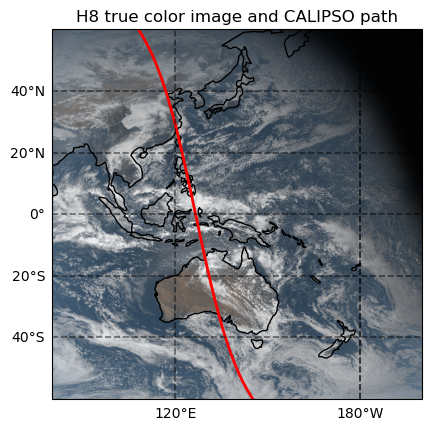

In [44]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 创建画图空间
proj = ccrs.PlateCarree(central_longitude=180) #创建投影
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}) #子图

# 设置地图属性:加载海岸线
ax.coastlines()  # type: ignore
# 设置网格点属性
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  # type: ignore
                  linewidth=1.2, color='k', alpha=0.5, linestyle='--')
ax.set_extent([80, 200, -60, 60], crs=ccrs.PlateCarree()) # type: ignore
gl.top_labels = False #关闭顶端标签
gl.right_labels = False #关闭右侧标签
gl.xformatter = LONGITUDE_FORMATTER #x轴设为经度格式
gl.yformatter = LATITUDE_FORMATTER #y轴设为纬度格式

# # 画图
# Phase1 = Phase.Phase#.sel(latitude = slice(-30, -60), longitude = slice(140, 190))
# levels=[-0.5, 0.5, 1.5, 2.5, 3.5]
# cmap = mpl.colors.ListedColormap(['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue'])  # type: ignore
# p_Phase = Phase1.plot(ax=ax, levels=levels, cmap=cmap, vmin=-0.5, vmax=3.5, add_colorbar=False, \
#     transform=ccrs.PlateCarree())

# # 设置colorbar
# ticklabels=['CS', 'WWC', 'SWC', 'IC']
# ticks = [0, 1, 2, 3]
# cb = fig.colorbar(p_Phase, shrink=0.75, pad=0.02)
# cb.ax.tick_params(direction='inout', length=5)
# cb.ax.set_yticks(ticks)
# cb.ax.set_yticklabels(ticklabels)

title = 'H8 true color image and CALIPSO path'
ax.set_title(title)

ax.imshow(RGB, transform = ccrs.PlateCarree(), extent=[80, 200, -60, 60])

idx = lons < 0
lons1 = lons + idx * 360

idxll = lats<-30

ax.plot(lons1, lats, color='r', linewidth=2.0, transform=ccrs.PlateCarree())

In [40]:
SOZ = H8['SOZ'].data
SAZ = H8['SAZ'].data
SAA = H8['SAA'].data
SOA = H8['SOA'].data
DAA = getDAA(SAA, SOA)
gTheta = glint(SOZ, SAZ, SAA, SOA)

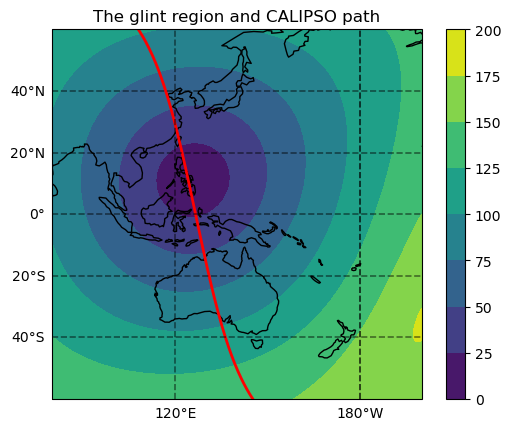

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 创建画图空间
proj = ccrs.PlateCarree(central_longitude=180) #创建投影
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}) #子图

# 设置地图属性:加载海岸线
ax.coastlines()  # type: ignore
# 设置网格点属性
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  # type: ignore
                  linewidth=1.2, color='k', alpha=0.5, linestyle='--')
ax.set_extent([80, 200, -60, 60], crs=ccrs.PlateCarree()) # type: ignore
gl.top_labels = False #关闭顶端标签
gl.right_labels = False #关闭右侧标签
gl.xformatter = LONGITUDE_FORMATTER #x轴设为经度格式
gl.yformatter = LATITUDE_FORMATTER #y轴设为纬度格式

title = 'The glint region and CALIPSO path'
ax.set_title(title)

glint_c = ax.contourf(gTheta, transform = ccrs.PlateCarree(), extent=[80, 200, -60, 60])
fig.colorbar(glint_c)

idx = lons < 0
lons1 = lons + idx * 360
idxll = lats<-30

ax.plot(lons1, lats, color='r', linewidth=2.0, transform=ccrs.PlateCarree())

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [14]:
def getH8CPH(pathname):
    H8CLP = xr.open_dataset(pathname)
    # 读取H8 CLP云相态分类数据
    ''' 
        Bits (6,5), (total 0-15), 
        Cloud Retrieval Phase Flag: 
                00=Clear, 
                01=Liquid Water, 
                10=Mixed or Uncertain, 
                11=Ice; 
    '''
    QA_H8CLP = H8CLP.QA
    QA_H8CLP.values.astype(np.int64)
    # 
    CPH_H8 = np.bitwise_and(QA_H8CLP.values.astype(np.int64),int('1100000',2))
    CPH_H8 = CPH_H8 >> 5
    # 创建画图空间
    proj = ccrs.PlateCarree(central_longitude=180) #创建投影
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}) #子图

    # 设置地图属性:加载海岸线
    ax.coastlines()  # type: ignore
    # 设置网格点属性
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,  # type: ignore
                    linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    ax.set_extent([80, 200, -60, 60], crs=ccrs.PlateCarree()) # type: ignore
    gl.top_labels = False #关闭顶端标签
    gl.right_labels = False #关闭右侧标签
    gl.xformatter = LONGITUDE_FORMATTER #x轴设为经度格式
    gl.yformatter = LATITUDE_FORMATTER #y轴设为纬度格式

    title = 'Cloud Phase from H8 CLP L2 Products'
    ax.set_title(title)


    # 画图
    levels=[-0.5, 0.5, 1.5, 2.5, 3.5]
    cmap = mpl.colors.ListedColormap(['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue']) # type: ignore
    # cmap = "GnBu"
    # p_Phase1 = Phase1.plot(ax=ax, levels=levels, cmap=cmap, add_colorbar=False, \
    #     transform=ccrs.PlateCarree())

    CPH_H8_c = ax.imshow(CPH_H8, transform = ccrs.PlateCarree(), cmap=cmap, extent=[80, 200, -60, 60])


    # 设置colorbar
    ticklabels=['CS', 'WC', 'MC', 'IC']
    ticks = [0, 1, 2, 3]
    cbar_kwargs = {
    # 'orientation': 'horizontal',
    # 'label': 'Potential',
    'shrink': 0.8,
    'ticks': ticks,
    # 'set_xticklabels': ticklabels
    }

    # p_Phase = ax.contourf(lon, lat, CPH_MYD06, cmap="GnBu", vmin=-0.5, vmax=3.5,
    # levels=levels, transform = ccrs.PlateCarree())

    cb = fig.colorbar(CPH_H8_c, shrink=0.75, pad=0.02)

    cb.ax.tick_params(direction='inout', length=5)
    cb.ax.set_yticks(ticks)
    cb.ax.set_yticklabels(ticklabels)

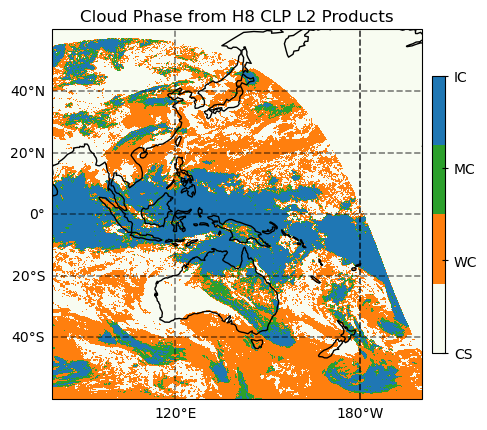

In [15]:
H8CLPpathname = '/home/fuhy/public/data/H8/L2/CLP/pub/himawari/L2/CLP/010/201701/01/05/NC_H08_20170101_0510_L2CLP010_FLDK.02401_02401.nc'
getH8CPH(H8CLPpathname)

In [61]:
# CALIPSO 起始观测时间
CALIPSO_duration = UTC[-1] - UTC[0]
print(timedelta(days=CALIPSO_duration).seconds/60)

Datestr = str(round(UTC[0]))
dt = datetime.datetime(2000+int(Datestr[0:2]),int(Datestr[2:4]),int(Datestr[4:6]))+\
    timedelta(days=(UTC[0] % 1))
print(dt)

print(timedelta(days=CALIPSO_duration).seconds/60/120*25)

dt_str = 'UTC: '+f'{dt:%Y-%m-%d %H:%M:%S%z}'
print(dt_str)

33.45
2017-01-01 05:01:06.292201
6.96875
UTC: 2017-01-01 05:01:06


In [38]:
# CALIPSO轨迹反演结果划分
latsCAL_CS  = df['lat'].values[preds_case==0]
latsCAL_WWC = df['lat'].values[preds_case==1]
latsCAL_SWC = df['lat'].values[preds_case==2]
latsCAL_IC  = df['lat'].values[preds_case==3]
eventsPhaselist = [latsCAL_CS, latsCAL_WWC, latsCAL_SWC, latsCAL_IC]

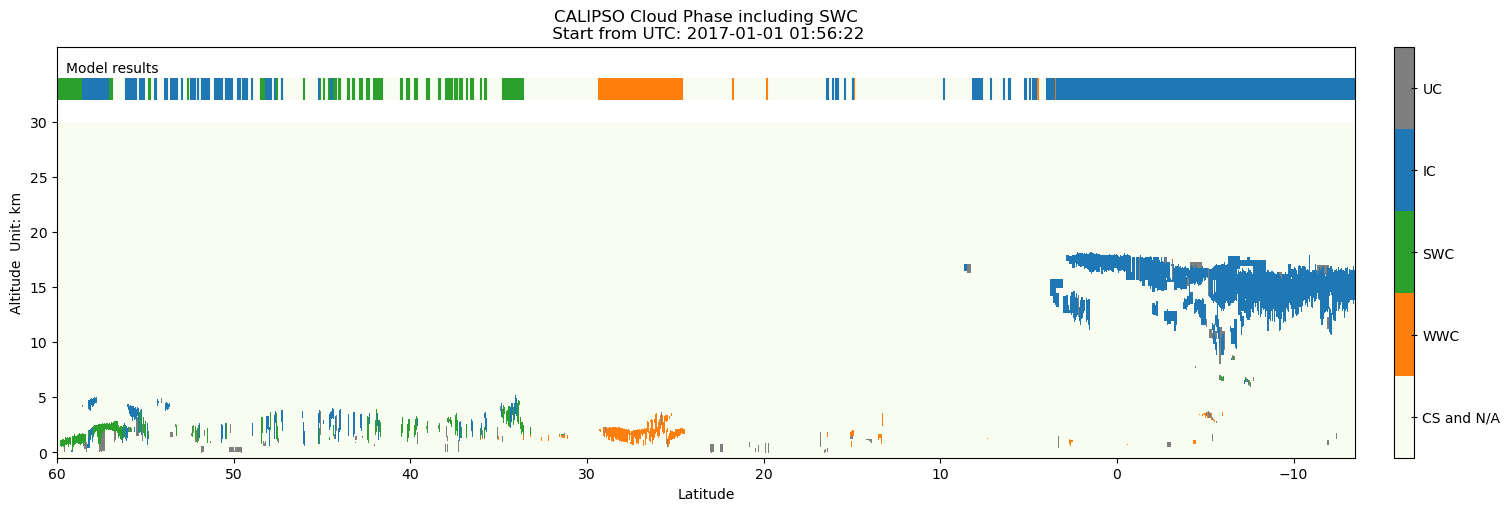

In [101]:
%matplotlib inline
import matplotlib.ticker as ticker
from matplotlib.colors import BoundaryNorm


fig, ax = plt.subplots(1, 1, figsize=(15, 5), layout='constrained') #子图
# fig, ax = plt.rcParams["figure.figsize"] = (10,5)

# colors = np.array(['tab:blue',[255,0,0],[0,0,255],[169,169,169]])/255.
# cmap = mpl.colormaps['tab20'] # type: ignore
cmap = mpl.colors.ListedColormap(['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue', 'tab:grey']) # type: ignore
levels = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
''' 
    注：
        不能用contouf等高线方式画图
        会导致插值显示
        对应显示结果错误
'''
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) # type: ignore

ac = plt.pcolormesh(lats, alt, cphase.T, cmap=cmap, norm=norm)
ax = plt.gca()
ax.invert_xaxis()
ax.set_title('CALIPSO Cloud Phase including SWC\n Start from '+dt_str)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude  Unit: km')

# ax.set_yticks([0, 1.5])
# ax.set_ylim(-0.5, 36)
# ax.set_yticks([33], labels=['Results']) 
ax.set_yticks(np.arange(0, 31, 5))
# ax.set_ybound(-0.5, 30)
# ax.grid(True) 
# ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 31, 5)))
ax.text(59.5, 34.5, 'Model results')

# 设置colorbar
ticklabels=['CS and N/A', 'WWC', 'SWC', 'IC', 'UC']
ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ac, ax=ax, orientation="vertical", pad=0.03)
cb.ax.tick_params(direction='inout', length=5)
cb.ax.set_yticks(ticks)
cb.ax.set_yticklabels(ticklabels)

# set different colors for each set of positions
colors1 = ['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue']

# set different line properties for each set of positions
# note that some overlap
lineoffsets1 = 33
linelengths1 = 2

# create a horizontal plot
for i in [0,1,2,3]:
    ax.eventplot(eventsPhaselist[i], colors=colors1[i], lineoffsets=lineoffsets1,
                    linelengths=linelengths1)
savename = 'results'+f'{dt:%Y%m%d%H%M}'+'.png'
fig.savefig(savename)

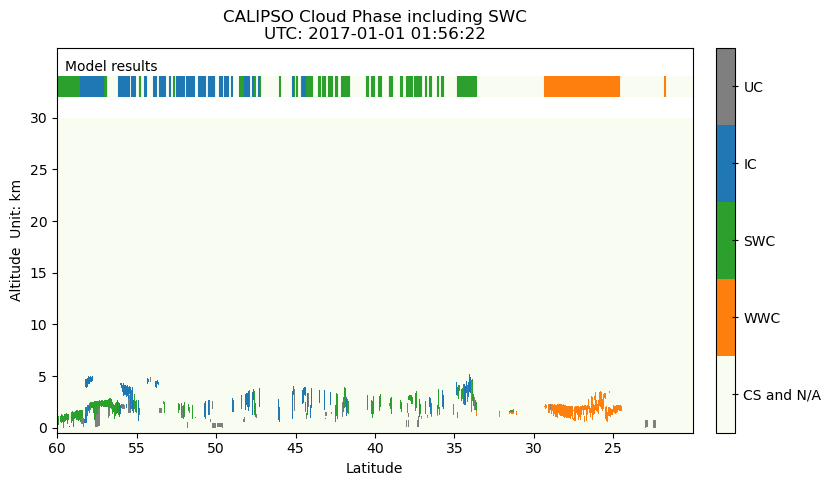

In [85]:
latmin = 20
latmax = 60

idxll = (lats<latmax) & (lats>latmin)

idx_latsCAL_CS  = (latsCAL_CS<latmax)  & (latsCAL_CS>latmin)
idx_latsCAL_WWC = (latsCAL_WWC<latmax) & (latsCAL_WWC>latmin)
idx_latsCAL_SWC = (latsCAL_SWC<latmax) & (latsCAL_SWC>latmin)
idx_latsCAL_IC  = (latsCAL_IC<latmax)  & (latsCAL_IC>latmin)

idx_latsCAL = [idx_latsCAL_CS,idx_latsCAL_WWC,idx_latsCAL_SWC,idx_latsCAL_IC]

%matplotlib inline
from matplotlib.colors import BoundaryNorm
plt.rcParams["figure.figsize"] = (10,5)

cmap = mpl.colors.ListedColormap(['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue', 'tab:grey']) # type: ignore
levels = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) # type: ignore

# ac = plt.pcolormesh(lats, alt, cphase.T, cmap=cmap, norm=norm)
ac = plt.pcolormesh(lats[idxll], alt, cphase[idxll,:].T, cmap=cmap, norm=norm)

ax = plt.gca()
ax.invert_xaxis()
ax.set_title('CALIPSO Cloud Phase including SWC\n'+dt_str)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude  Unit: km')
# ax.set_yticks([0, 1.5])
# ax.set_ylim(-0.5, 36)
# ax.set_yticks([33], labels=['Results']) 
ax.set_yticks(np.arange(0, 31, 5))
# ax.set_ybound(-0.5, 30)
# ax.grid(True) 
# ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 31, 5)))
ax.text(latmax-0.5, 34.5, 'Model results')


# 设置colorbar
ticklabels=['CS and N/A', 'WWC', 'SWC', 'IC', 'UC']
ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ac, ax=ax, orientation="vertical", pad=0.03)
cb.ax.tick_params(direction='inout', length=5)
cb.ax.set_yticks(ticks)
cb.ax.set_yticklabels(ticklabels)

# set different colors for each set of positions
colors1 = ['#F8FCF1', 'tab:orange', 'tab:green', 'tab:blue']
# colors1 = ['C{}'.format(i) for i in range(4)]

# set different line properties for each set of positions
# note that some overlap
lineoffsets1 = 33
linelengths1 = 2

# create a horizontal plot
for i in [0,1,2,3]:
    ax.eventplot(eventsPhaselist[i][idx_latsCAL[i]], colors=colors1[i], lineoffsets=lineoffsets1,
                    linelengths=linelengths1)